In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K
import xgboost as xgb
import os

from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout, Conv1D, MaxPooling1D, Convolution1D
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization

%matplotlib inline

/home/akpurohi/.conda/envs/python_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# X_training = pickle.load(open("X_train.pickle","rb"))
# Y_training = pickle.load(open("Y_train.pickle","rb"))
# X_testing = pickle.load(open("X_test.pickle","rb"))
# Y_testing = pickle.load(open("Y_test.pickle","rb"))

# X_training_un = pickle.load(open("X_train_un.pickle","rb"))
# Y_training_un = pickle.load(open("Y_train_un.pickle","rb"))
# X_testing_un = pickle.load(open("X_test_un.pickle","rb"))
# Y_testing_un = pickle.load(open("Y_test_un.pickle","rb"))


data_dir = '../data2'

X_training = np.load(os.path.join(data_dir, "X_train_f100.npy"))#"../data2/X_train_f100.npy")
Y_training = np.load(os.path.join(data_dir, "Y_train_f100.npy"))#"../data2/Y_train_f100.npy")

X_val = np.load(os.path.join(data_dir, "X_val_f100.npy"))#"../data2/X_val_f100.npy")
Y_val = np.load(os.path.join(data_dir, "Y_val_f100.npy"))#"../data2/Y_val_f100.npy")

X_testing = np.load(os.path.join(data_dir, "X_test_f100.npy"))#"../data2/X_test_f100.npy")
Y_testing = np.load(os.path.join(data_dir, "Y_test_f100.npy"))#"../data2/Y_test_f100.npy")

# X_training_un = pickle.load(open("X_train_un.pickle","rb"))
# Y_training_un = pickle.load(open("Y_train_un.pickle","rb"))
# X_testing_un = pickle.load(open("X_test_un.pickle","rb"))
# Y_testing_un = pickle.load(open("Y_test_un.pickle","rb"))


# X_training = np.concatenate((X_training, X_training_un), axis=0)
# Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
# X_val = X_testing
# Y_val = Y_testing
# X_testing = np.concatenate((X_testing, X_testing_un), axis=0)
# Y_testing = np.concatenate((Y_testing, Y_testing_un), axis=0)


# Centering and Normalizing data


# X_training = X_training[0:10]
# Y_training = Y_training[0:10]

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

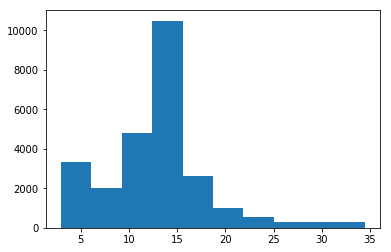

In [4]:
plt.hist(Y_training)
plt.show()

In [5]:
def get_model(batch_size, data_dim = 100):
    nb_filters = 200
#     model = Sequential()
#     model.add(Conv1D(input_shape = (data_dim, 1), filters = nb_filters, 
#                      kernel_size = 10, activation='tanh', name="Conv1"))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters = nb_filters, kernel_size = 5, 
#                      activation='relu', name="Conv2"))
#     model.add(Flatten())
#     model.add(Dense(2048, activation='relu', name="Dense1"))
#     model.add(Dropout(0.2))
#     model.add(Dense(1024, activation='relu', name="Dense2"))
#     model.add(Dense(1))
    
    inputs = Input(shape = (data_dim, 1))
    conv_1 = Convolution1D(filters = nb_filters, kernel_size = 3,
                    activation='tanh', name="Conv1")(inputs)
    maxpool_1 = MaxPooling1D(name="maxpool1")(conv_1)
    batch_norm1 = BatchNormalization( name = "batch_norm_1")(maxpool_1)
    conv_2 = Convolution1D(filters = nb_filters, kernel_size = 2, 
                     activation='relu', name="Conv2")(batch_norm1)
    maxpool_2 = MaxPooling1D(name="maxpool2")(conv_2)
    batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
    conv_3 = Convolution1D(filters = nb_filters, kernel_size = 2, 
                     activation='relu', name="Conv3")(batch_norm2)
    maxpool_3 = MaxPooling1D(name="maxpool3")(conv_3)
#     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
    flatten = Flatten()(maxpool_3)
    dense_1 = Dense(1024, activation='relu', name="Dense1")(flatten)
    dropout_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(512, activation='relu', name="Dense2")(dropout_1)
    dropout_1 = Dropout(0.4)(dense_2)
    output = Dense(1, name="output")(dense_2)
    model = Model(inputs = inputs, output = output)
    
    return model

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 1)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 15, 200)           600       
_________________________________________________________________
maxpool1 (MaxPooling1D)      (None, 7, 200)            0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 7, 200)            800       
_________________________________________________________________
Conv2 (Conv1D)               (None, 6, 200)            80200     
_________________________________________________________________
maxpool2 (MaxPooling1D)      (None, 3, 200)            0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 3, 200)            800       
__________

In [7]:
X_training.shape[1]

16

In [ ]:
n_epochs = 50
data_dim = X_training.shape[1]
batch_size = 20
L=len(X_training)
n_Iter = int(L/batch_size)

optimizer = optimizers.RMSprop()#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(batch_size, data_dim)
model.compile(loss="mse", optimizer=optimizer)

val_data = (np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)), Y_val)
Y_train = np.reshape( Y_training, (L, 1, 1) )
X_train = np.reshape( X_training, (L, X_training.shape[1], 1) )



# for epoch in range(n_epochs):
#     pos = 0
#     for itr in range(n_Iter):
# #         trainX = X_training[pos: pos+batch_size]
# #         trainY = Y_training[pos: pos+batch_size]
#         trainX = np.reshape(X_training[pos: pos+batch_size], (1, batch_size, X_training.shape[1]))
#         trainY = np.reshape(Y_training[pos: pos+batch_size], (1, batch_size, 1))
#         model.fit(trainX, trainY, validation_data = val_data)
#         pos += batch_size

model.fit(x=X_train, y=Y_training, batch_size=batch_size, epochs=n_epochs, validation_data=val_data)

/home/akpurohi/.conda/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Train on 25694 samples, validate on 11012 samples
Epoch 1/50
25694/25694 [==============================] - 69s 3ms/step - loss: 25.1263 - val_loss: 31.7733
Epoch 2/50
25694/25694 [==============================] - 57s 2ms/step - loss: 11.8638 - val_loss: 43.2634
Epoch 3/50
25694/25694 [==============================] - 56s 2ms/step - loss: 10.7171 - val_loss: 27.6724
Epoch 4/50
25694/25694 [==============================] - 60s 2ms/step - loss: 9.8121 - val_loss: 30.3202
Epoch 5/50
25694/25694 [==============================] - 67s 3ms/step - loss: 9.1218 - val_loss: 35.1738
Epoch 6/50
25694/25694 [==============================] - 60s 2ms/step - loss: 8.6094 - val_loss: 29.1957
Epoch 7/50
25694/25694 [==============================] - 57s 2ms/step - loss: 8.2801 - val_loss: 27.9545
Epoch 8/50
25694/25694 [==============================] - 61s 2ms/step - loss: 7.8571 - val_loss: 37.4318
Epoch 9/50
25694/25694 [==============================] - 65s 3ms/step - loss: 7.5249 - val_loss: 3

In [ ]:
# # Save model
# model.save('model_mlp_time_data.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

In [ ]:
# 100 components, full data, n_estimators = 100, reg:gamma
preds = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
rmse = np.sqrt(mean_squared_error(preds, Y_val)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Val RMSE:", rmse)

preds = model.predict(np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1)))
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_testing,'r',linewidth=1.0)
plt.legend(['Precitions', 'Ground Truth'])
plt.show()

rmse = np.sqrt(mean_squared_error(preds, Y_testing)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Test RMSE:", rmse)